In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

In [2]:
from scipy.linalg import eigh

In [3]:
def update_segs(ll,u):
    segs = ll.get_segments()
    for (ii,seg) in enumerate(segs):
        seg[1,1] = u[ii]
    ll.set_segments(segs)

# General solution of coupled harmonic oscillators

Solve coupled harmonic oscillator equations defined by matrices $M$ and $K$ where
\begin{equation}
M \frac{\mathrm{d}^2\vec{q}}{\mathrm{d}t^2} + K \vec{q} = 0
\end{equation}
Assuming harmonic time dependence, $q_n \propto e^{i\omega_n t}$, this is equal to
\begin{gather}
-\omega_n^2 M \vec{q}_n + K \vec{q}_n = 0\\
K \vec{q}_n = \omega_n^2 M \vec{q}_n
\end{gather}

In [4]:
class coupled_harmosc:
    def __init__(self,M,K):
        N = K.shape[0]
        ωssq, As = eigh(K,M)
        ωs = np.sqrt(ωssq)
        assert np.allclose(As.T @ M @ As,np.eye(N))
        self.K = K
        self.M = M
        self.ωs = ωs
        self.As = As
    def solve(self,q0,v0,t):
        # q(t) = As (Rcs cos(ωs t) + Ics sin(ωs t))
        # v(t) = As ωs (-Rcs sin(ωs t) + Ics cos(ωs t))
        # q0 = As Rcs -> As^T M q0 = As^T M As Rcs = Rcs
        # v0 = As ωs Ics -> As^T M v0 = As^T M As ωs Ics = ωs Ics
        Rcs = self.As.T @ self.M @ q0
        Ics = (self.As.T @ self.M @ v0) / self.ωs
        self.cs = Rcs + 1j*Ics
        cst = self.cs[:,None]*np.exp(-1j*self.ωs[:,None]*t[None,:])
        self.Q = np.real(cst)
        self.V = self.ωs[:,None] * np.imag(cst)
        self.q = self.As @ self.Q
        self.v = self.As @ self.V
        self.t = t

## Two coupled oscillators

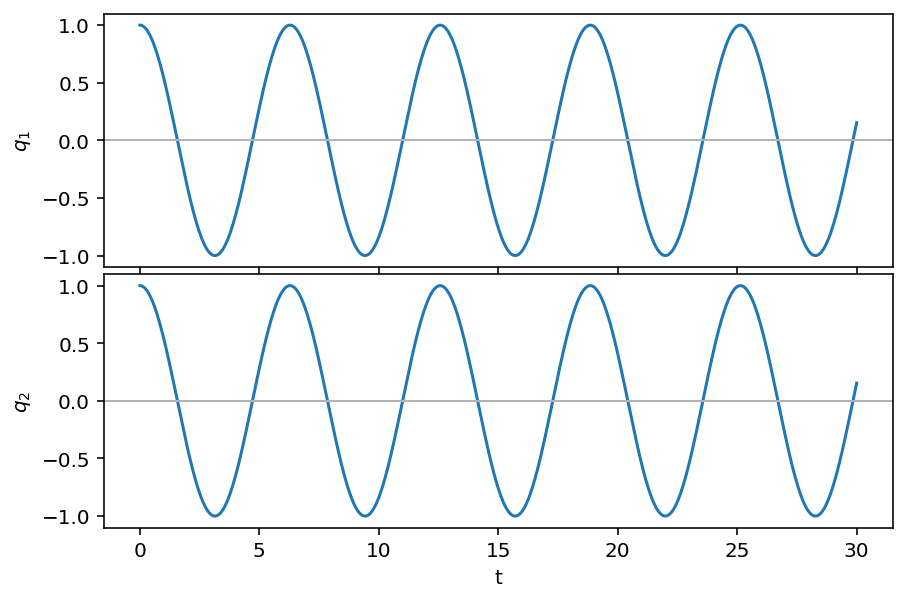

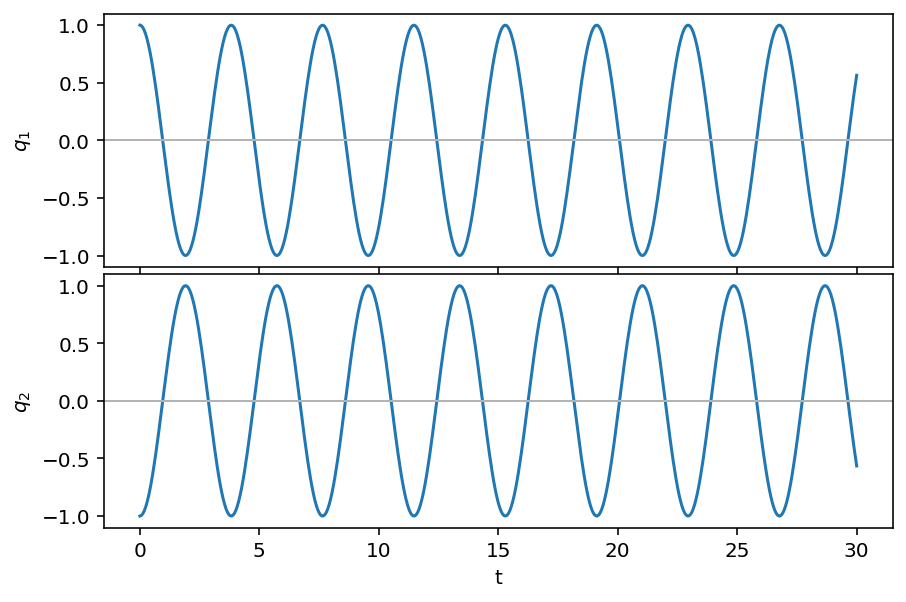

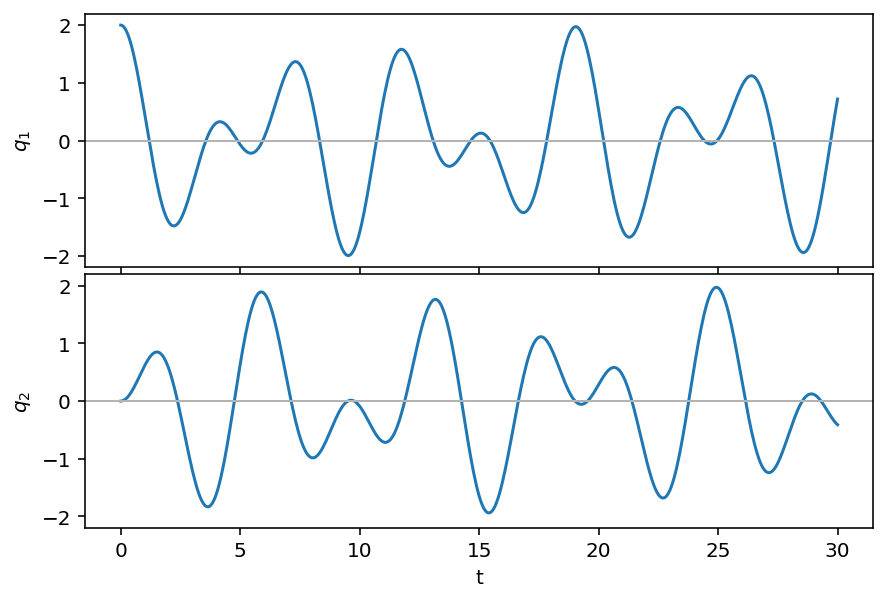

In [5]:
k = 1.
kp = 0.85
K = np.array([[k+kp,-kp],[-kp,k+kp]])
M = np.array([[1.,0.],[0.,1]])
ch = coupled_harmosc(M,K)

t = np.linspace(0,30,501)
v0 = [0.,0.]
for q0 in ([1.,1.], [1.,-1.], [2.,0]):
    ch.solve(q0,v0,t)
    f,axs = plt.subplots(2,1,sharex=True,sharey=True)
    for (ii,ax) in enumerate(axs):
        ax.plot(ch.t,ch.q[ii,:])
        ax.set_ylabel(f"$q_{ii+1}$")
        ax.axhline(0,lw=1,color="0.7")
    axs[1].set_xlabel("t")
    f.tight_layout(pad=0)

## Chain of coupled oscillators

In [6]:
N = 61
xs = np.linspace(-1,1,N)
ms = np.ones(N)
ωs = np.ones(N)
gs = (-.5 * ms * ωs**2)[1:]
M = np.diag(ms)
K = np.diag(ms*ωs**2)
K[range(1,N),range(N-1)] = K[range(N-1),range(1,N)] = gs
ch = coupled_harmosc(M,K)

In [7]:
q0 = np.exp(-xs**2/(2*0.15**2))
v0 = np.zeros_like(q0)
t = np.linspace(0.,200.,801)
ch.solve(q0,v0,t)

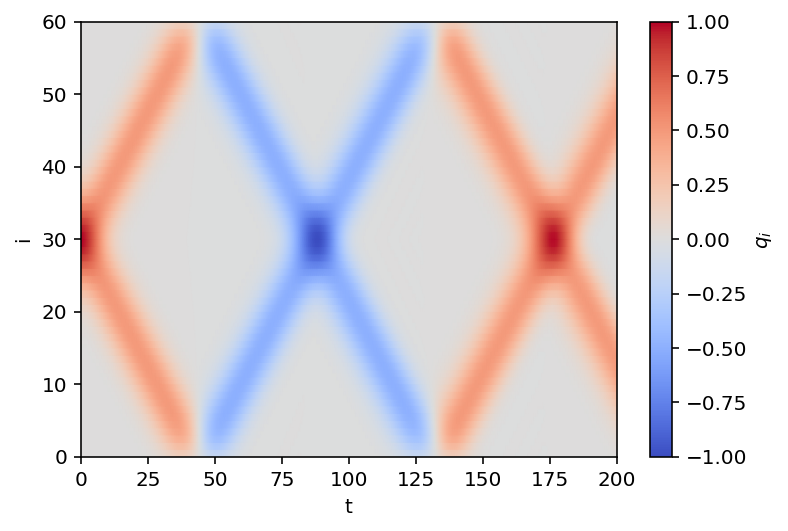

In [8]:
plt.figure()
plt.pcolormesh(ch.t,range(N),ch.q,cmap="coolwarm",vmax=1,vmin=-1,shading='gouraud');
plt.xlabel("t")
plt.ylabel("i")
cb = plt.colorbar();
cb.set_label("$q_i$")

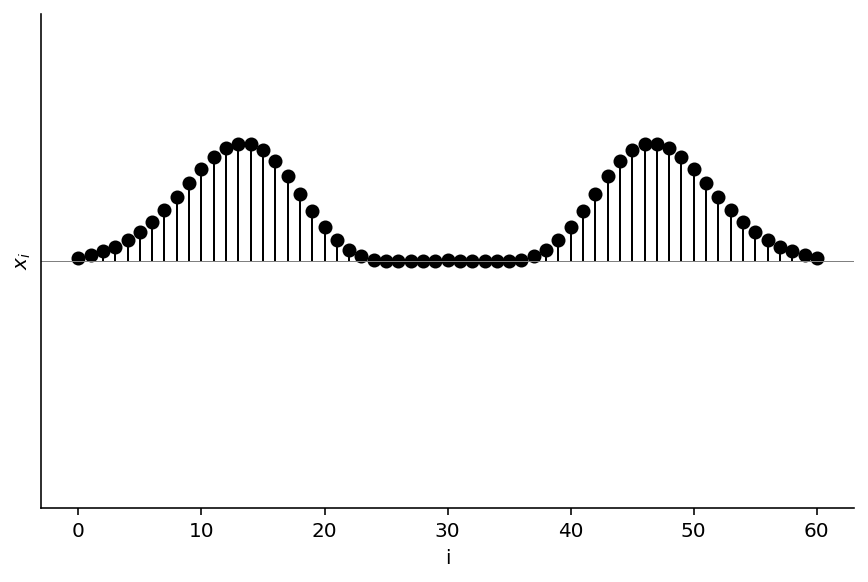

In [9]:
fig, ax = plt.subplots()
ln, = ax.plot(range(N), ch.q[:,0], "ko")
ll = ax.vlines(range(N), 0, ch.q[:,0], lw=1)
ax.axhline(0,lw=0.5,color="0.5")
ax.set_ylim(-1.04,1.04)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([])
ax.set_xlabel("i")
ax.set_ylabel("$x_i$")
fig.tight_layout(pad=0.5)

mw = anim.FFMpegWriter(fps=25)
with mw.saving(fig,"oscillator_chain_wavepacket.mp4",100):
    for q in ch.q.T:
        ln.set_ydata(q)
        update_segs(ll,q)
        mw.grab_frame()

(0, 30)

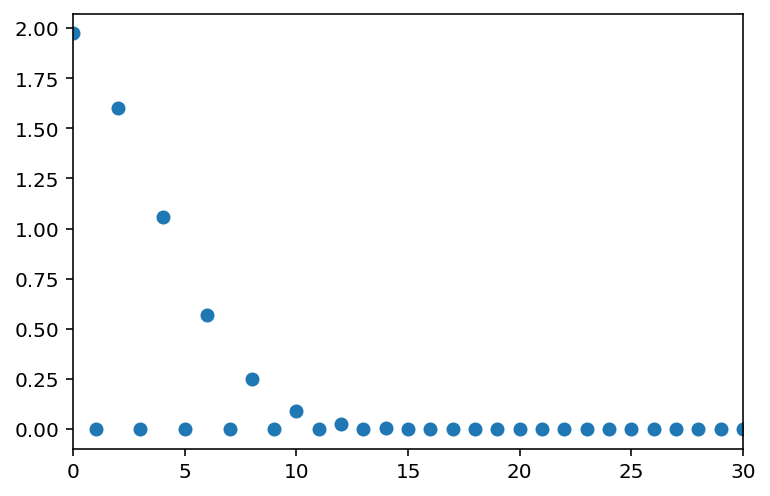

In [10]:
plt.plot(range(N),abs(ch.cs),"o")
plt.xlim(0,30)

[ 0  2  4  6  8 10]


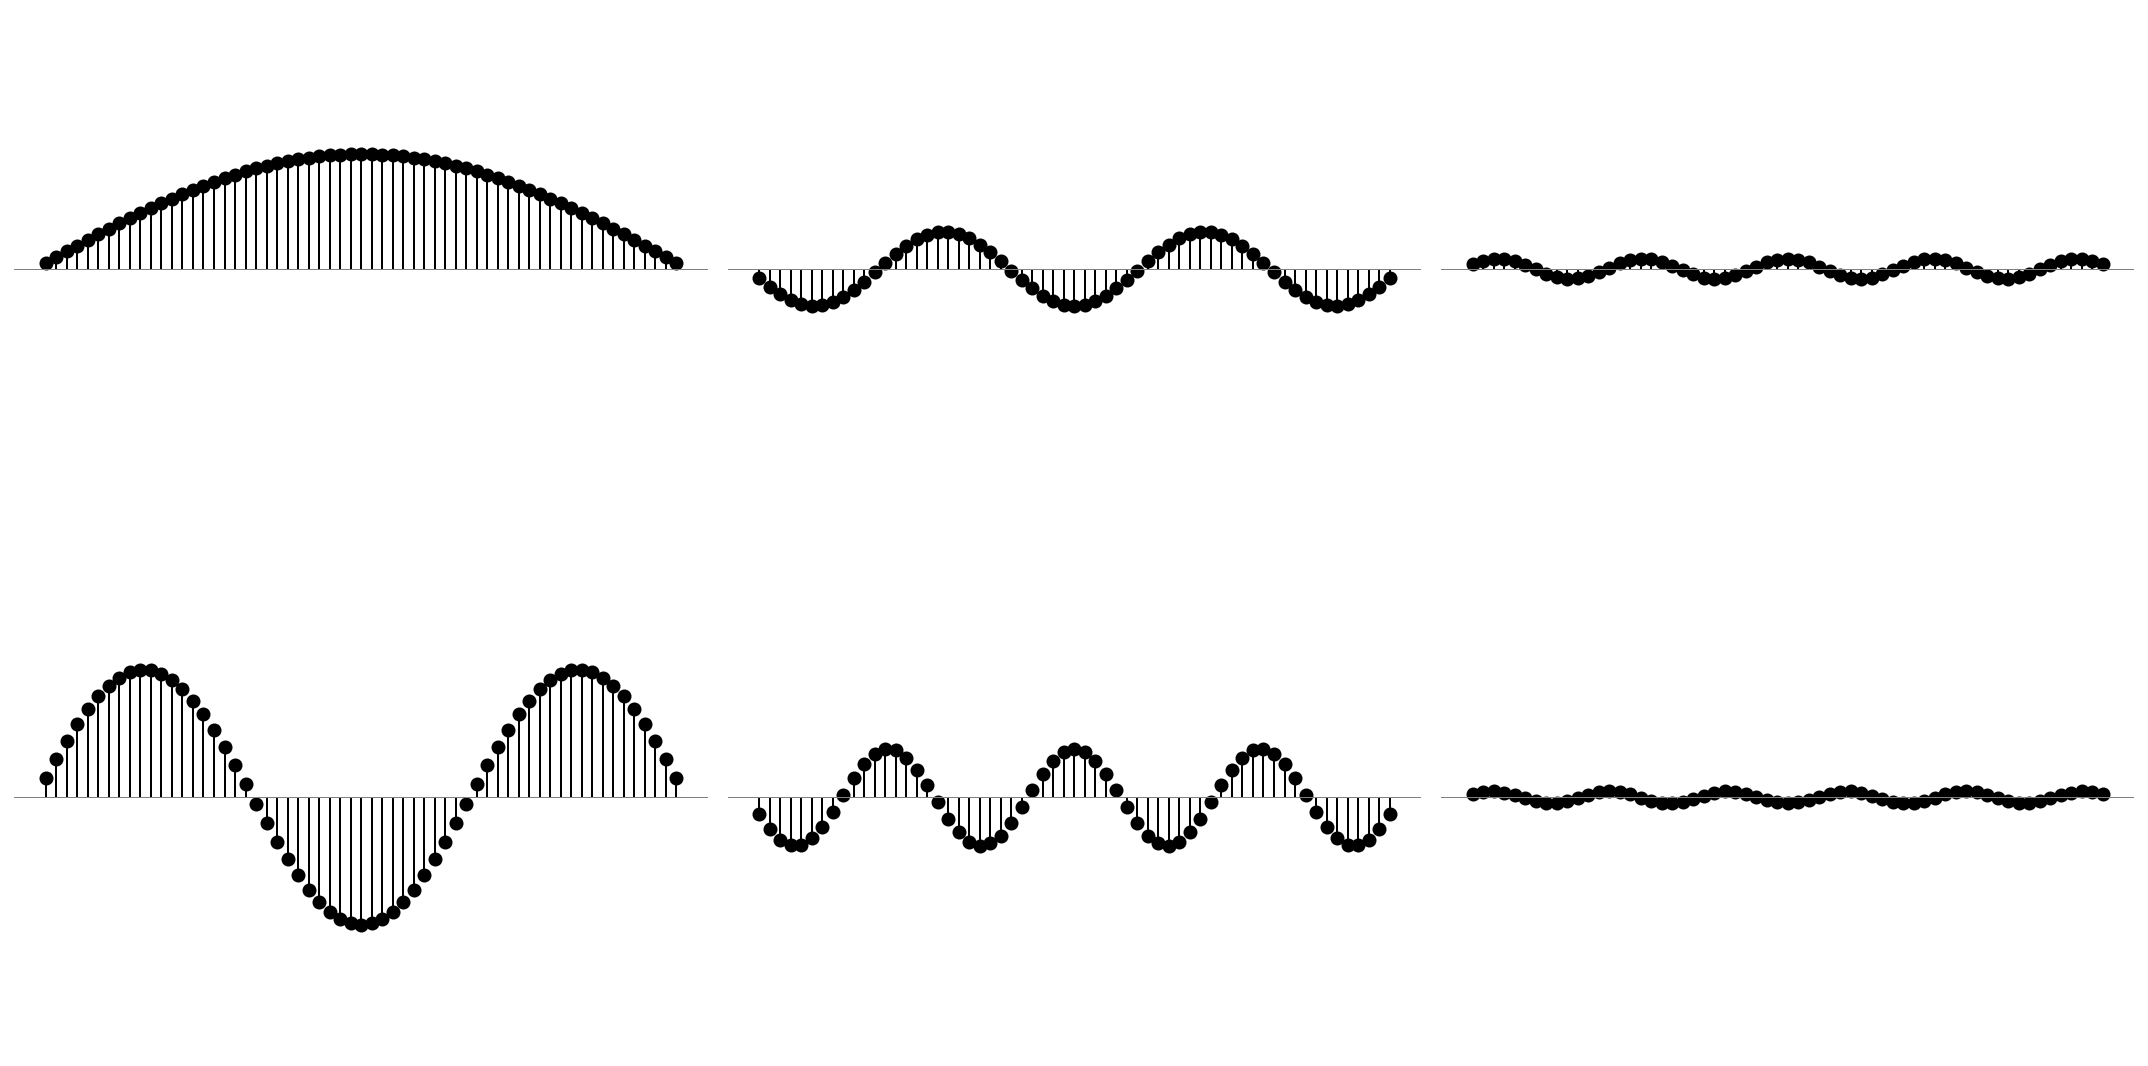

In [11]:
takeinds, = np.where(abs(ch.cs)>0.04)
print(takeinds)

fig, axs = plt.subplots(2,(len(takeinds)+1)//2,figsize=(15,7.5),sharex=True,sharey="row")
lns = []
normal_modes = []
for (ii,ax) in zip(takeinds,axs.T.flat):
    nm = np.real(ch.cs[ii] * ch.As[None,:,ii] * np.exp(-1j*ch.ωs[ii]*t[:,None]))
    normal_modes.append(nm)
    ln, = ax.plot(range(N), nm[0], "ko")
    ll  = ax.vlines(range(N), 0, nm[0], lw=1)
    ax.axhline(0,lw=0.5,color="0.5")
    ax.set_ylim(-0.5,0.5)
    ax.axis("off")
    lns.append((ln,ll))
fig.tight_layout(pad=1)

mw = anim.FFMpegWriter(fps=25)
with mw.saving(fig,"oscillator_chain_modes.mp4",50):
    for it in range(len(t)):
        for ((ln,ll),nm) in zip(lns,normal_modes):
            ln.set_ydata(nm[it])
            update_segs(ll,nm[it])
        mw.grab_frame()